In [12]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
conn = create_engine('sqlite:///data/starbucks_data.db')

offers = pd.read_sql('SELECT DISTINCT offer_id, offer_duration, offer_type, offer_spend_minimum, offer_reward, offer_reward_vs_spend FROM offers', conn)
offer_duration = offers[['offer_id', 'offer_duration']].drop_duplicates()

interactions = pd.read_sql('SELECT * FROM interactions', conn)

users = pd.read_sql('SELECT user_id, user_gender, user_tenure, user_age_group, user_income_group FROM users', conn)

users['user_gender'] = users['user_gender'].fillna('N/A')
user_gender_cats = [ 'N/A', 'O', 'F', 'M' ]
users['user_gender'] = pd.Categorical(users['user_gender'], categories=user_gender_cats, ordered=True)

users['user_age_group'] = users['user_age_group'].fillna('N/A')
user_age_cats = ['N/A', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=user_age_cats, ordered=True)

user_income_cats = ['N/A', '<50k', '50k-75k', '75k-100k', '>100k']
users['user_income_group'] = pd.Categorical(users['user_income_group'], categories=user_income_cats, ordered=False)

In [14]:
base_col_order = ['user_id', 'offer_id', 'intxn_event_type', 'intxn_time', 'intxn_amount', 'intxn_reward']

offer_received = interactions[ interactions['intxn_event_type'] == 'offer received' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_received_cols = [ "received" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_received.columns ]
offer_received.columns = offer_received_cols

offer_received = pd.merge(offer_received, offer_duration, how='left', on='offer_id')
offer_received['expiration_time'] = offer_received['received_time'] + offer_received['offer_duration']
offer_received = offer_received.drop(columns=['offer_duration'])

offer_viewed = interactions[ interactions['intxn_event_type'] == 'offer viewed' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_viewed_cols = [ "viewed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_viewed.columns ]
offer_viewed.columns = offer_viewed_cols

offer_completed = interactions[ interactions['intxn_event_type'] == 'offer completed' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_completed_cols = [ "completed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_completed.columns ]
offer_completed.columns = offer_completed_cols

transactions = interactions[ interactions['intxn_event_type'] == 'transaction' ].copy().drop(['offer_id', 'intxn_event_type', 'intxn_reward'], axis=1)
transactions_cols = [ "transaction" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in transactions.columns ]
transactions.columns = transactions_cols

# Getting the recieved offers that were viewed afterwards

In [15]:
# Merging offer_received to offer_viewed to get the offer expiration times
offer_interactions = pd.merge( offer_received, offer_viewed, on=['user_id', 'offer_id'], how='left' )
offer_interactions = offer_interactions[ ~offer_interactions['viewed_time'].isna() ]

# Removing duplicates from the join where the received time would be after the viewed time and the viewed time would be after the expiration time
offer_interactions = offer_interactions[  ( offer_interactions['viewed_time'] >= offer_interactions['received_time'] ) & ( offer_interactions['viewed_time'] <= offer_interactions['expiration_time'] ) ]
offer_interactions = offer_interactions.sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time']).drop_duplicates(subset=['offer_id', 'user_id', 'received_time', 'expiration_time'], keep='first')

display( offer_interactions.sort_values(['user_id', 'offer_id', 'received_time', 'viewed_time']) )

,user_id,offer_id,received_time,expiration_time,viewed_time
35295,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,432,372.0
19437,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,240,192.0
51166,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,528,456.0
66965,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,744,540.0
20066,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,288,216.0
...,...,...,...,...,...
33595,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,504,354.0
49455,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,576,414.0
81024,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,576,744,582.0
65289,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,672,534.0


# Getting the recieved and viewed offers that had transactions afterwards

In [16]:
offer_interactions = pd.merge( offer_interactions, transactions, on=[ 'user_id' ], how='left' )
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] >= offer_interactions['received_time'] ) ]
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] >= offer_interactions['viewed_time'] ) ]
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] <= offer_interactions['expiration_time'] ) ]

offer_interactions = offer_interactions.sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time']).drop_duplicates(subset=['offer_id', 'user_id', 'received_time', 'expiration_time', 'viewed_time'], keep='first')
offer_interactions = offer_interactions.drop(columns=['transaction_amount'])

display( offer_interactions.sort_values( ['user_id', 'offer_id', 'received_time', 'viewed_time', 'transaction_time'] ) )

,user_id,offer_id,received_time,expiration_time,viewed_time,transaction_time
9,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,432,372.0,414.0
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,240,192.0,228.0
18,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,528,456.0,528.0
27,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,744,540.0,552.0
55,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,648,432.0,576.0
...,...,...,...,...,...,...
489772,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,504,354.0,384.0
489788,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,576,414.0,414.0
489822,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,576,744,582.0,606.0
489806,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,672,534.0,576.0


# Getting the recieved, viewed, and transacted offers that had completions

In [17]:
offer_interactions = pd.merge( offer_interactions, offer_completed, on=[ 'user_id', 'offer_id' ], how='left' )
offer_interactions = offer_interactions[ ( offer_interactions['completed_time'].isna() ) | ( offer_interactions['completed_time'] == offer_interactions['transaction_time'] ) ]
offer_interactions = offer_interactions.sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time', 'completed_time']).drop_duplicates(subset=['offer_id', 'user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time'], keep='first')

display( offer_interactions.sort_values(['user_id', 'offer_id', 'received_time', 'viewed_time', 'transaction_time']) )

,user_id,offer_id,received_time,expiration_time,viewed_time,transaction_time,completed_time
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,432,372.0,414.0,NaN
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,240,192.0,228.0,NaN
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,648,432.0,576.0,576.0
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,336,186.0,252.0,252.0
6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,672,516.0,576.0,576.0
...,...,...,...,...,...,...,...
53569,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,408,528,510.0,516.0,516.0
53572,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,408,174.0,198.0,198.0
53573,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,504,354.0,384.0,384.0
53577,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,576,414.0,414.0,414.0


# Creating flags

In [18]:
offer_interactions['had_transaction'] = ~offer_interactions['transaction_time'].isna()
offer_interactions['had_transaction'] = offer_interactions['had_transaction'].apply( lambda x: 1 if x else 0 )

offer_interactions['completed_offer'] = ~offer_interactions['completed_time'].isna()
offer_interactions['completed_offer'] = offer_interactions['completed_offer'].apply( lambda x: 1 if x else 0 )

offer_interactions = offer_interactions.groupby( ['user_id', 'offer_id'], observed=False, dropna=False ).agg( offer_transactions=( 'had_transaction', 'sum' ), offer_completions=( 'completed_offer', 'sum') ).reset_index()

display( offer_interactions )

,user_id,offer_id,offer_transactions,offer_completions
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
...,...,...,...,...
32118,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,1,0
32119,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2
32120,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
32121,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,2


In [19]:
offer_demographics = pd.merge( offer_interactions, users, on='user_id', how='left' )
offer_demographics = pd.merge( offer_demographics, offers, on='offer_id', how='left' )

display(offer_demographics)

,user_id,offer_id,offer_transactions,offer_completions,user_gender,user_tenure,user_age_group,user_income_group,offer_duration,offer_type,offer_spend_minimum,offer_reward,offer_reward_vs_spend
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,M,1,25-34,50k-75k,96,informational,0,0,0.00
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,M,1,25-34,50k-75k,72,informational,0,0,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,O,0,35-44,50k-75k,240,discount,20,5,0.25
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,O,0,35-44,50k-75k,168,discount,7,3,0.43
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,O,0,35-44,50k-75k,168,bogo,5,5,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32118,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,1,0,M,1,25-34,<50k,72,informational,0,0,0.00
32119,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,M,1,25-34,<50k,120,bogo,5,5,1.00
32120,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,F,2,45-54,50k-75k,240,discount,20,5,0.25
32121,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,2,F,2,45-54,50k-75k,168,discount,10,2,0.20


In [20]:
demographics_cols = [ 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group', 'offer_duration', 'offer_type', 'offer_spend_minimum', 'offer_reward', 'offer_reward_vs_spend' ]
aggregated_offers = offer_demographics.groupby( demographics_cols, observed=False, dropna=False ).agg( offer_transactions=('offer_transactions', 'sum'), offer_completions=('offer_completions', 'sum') ).reset_index()

aggregated_offers

,user_gender,user_tenure,user_age_group,user_income_group,offer_duration,offer_type,offer_spend_minimum,offer_reward,offer_reward_vs_spend,offer_transactions,offer_completions
0,N/A,0,N/A,N/A,72,bogo,0,0,0.00,0,0
1,N/A,0,N/A,N/A,72,bogo,0,0,0.20,0,0
2,N/A,0,N/A,N/A,72,bogo,0,0,0.25,0,0
3,N/A,0,N/A,N/A,72,bogo,0,0,0.43,0,0
4,N/A,0,N/A,N/A,72,bogo,0,0,1.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1574995,M,5,65+,>100k,240,informational,20,10,0.00,0,0
1574996,M,5,65+,>100k,240,informational,20,10,0.20,0,0
1574997,M,5,65+,>100k,240,informational,20,10,0.25,0,0
1574998,M,5,65+,>100k,240,informational,20,10,0.43,0,0


<Axes: xlabel='user_gender', ylabel='offer_transactions'>

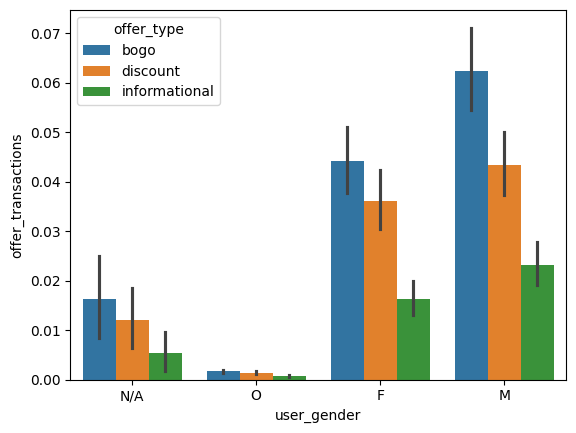

In [22]:
sns.barplot( data=aggregated_offers, x='user_gender', y='offer_transactions', hue='offer_type' )